Generando datos TEM sintéticos para modelo de 5 capas...


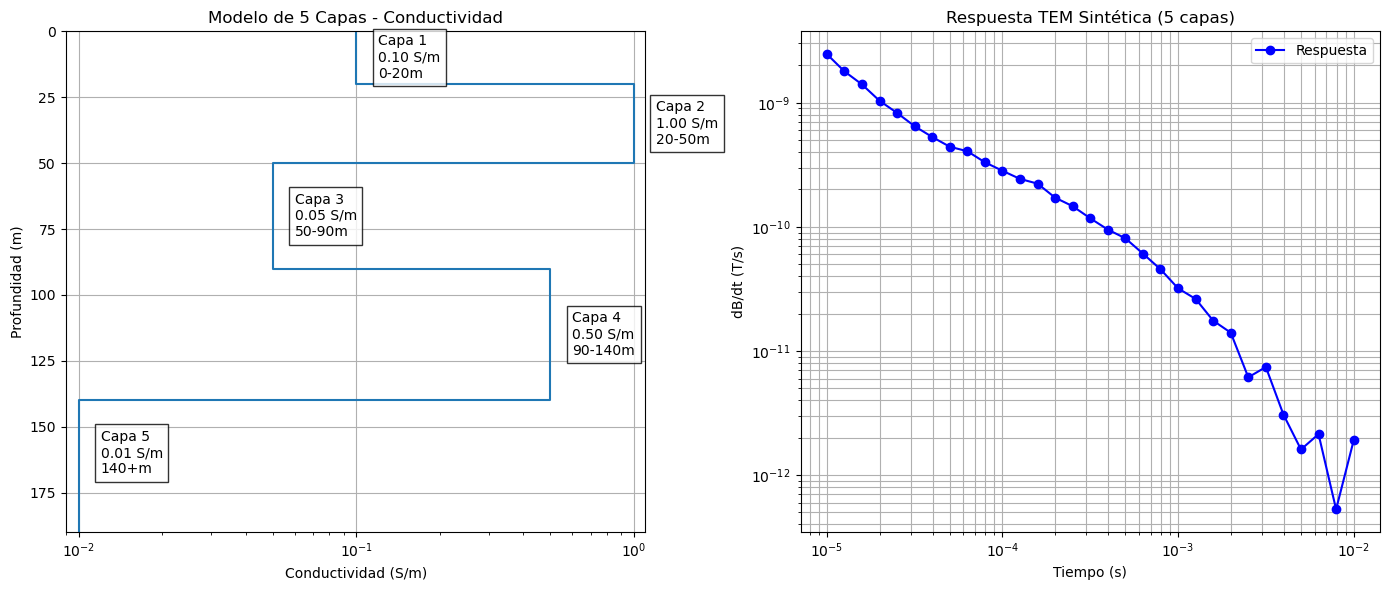


¡Simulación completada!
Datos guardados en 'em1dtm_5layers_data.txt'

Modelo utilizado (5 capas):
Capa 1: 0-20m, σ = 0.10 S/m
Capa 2: 20-50m, σ = 1.00 S/m
Capa 3: 50-90m, σ = 0.05 S/m
Capa 4: 90-140m, σ = 0.50 S/m
Capa 5: 140+m, σ = 0.01 S/m


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.utils import plot_1d_layer_model
from SimPEG import maps

# Configuración de parámetros
source_location = np.array([0.0, 0.0, 1.0])  # Posición de la fuente [x,y,z]
source_orientation = "z"  # Orientación del dipolo
source_current = 1.0  # Corriente en Amperios
source_radius = 10.0  # Radio del loop en metros

# Configuración del receptor
receiver_location = np.array([0.0, 0.0, 1.0])  # Misma ubicación que la fuente
receiver_orientation = "z"  # Componente a medir
times = np.logspace(-5, -2, 31)  # Ventanas temporales desde 10μs a 100ms

# Modelo de 5 capas
layer_conductivities = np.r_[0.1, 1.0, 0.05, 0.5, 0.01]  # Conductividades en S/m
layer_thicknesses = np.r_[20.0, 30.0, 40.0, 50.0]  # Espesores en metros (la última capa es semi-infinita)

def create_tem_survey():
    """Crea y configura el survey TEM"""
    # Waveform step-off
    waveform = tdem.sources.StepOffWaveform(off_time=0.0)

    # Configurar receptor
    receiver = tdem.receivers.PointMagneticFluxDensity(
        receiver_location,
        times,
        orientation=receiver_orientation
    )

    # Configurar fuente
    source = tdem.sources.CircularLoop(
        receiver_list=[receiver],
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius
    )

    return tdem.Survey([source])

def run_simulation():
    """Ejecuta la simulación TEM 1D para 5 capas"""
    # Crear survey
    survey = create_tem_survey()

    # Configurar simulación 1D en capas
    simulation = tdem.Simulation1DLayered(
        survey=survey,
        thicknesses=layer_thicknesses,
        sigmaMap=maps.IdentityMap(nP=len(layer_conductivities))
    )

    # Calcular respuesta sintética
    dpred = simulation.dpred(layer_conductivities)

    # Añadir ruido realista (2% + piso de ruido)
    noise = 0.02 * np.abs(dpred) + 1e-12
    dobs = dpred + noise * np.random.randn(len(dpred))

    return times, dobs, layer_conductivities, layer_thicknesses

def plot_results(times, response, sigma, thicknesses):
    """Visualiza los resultados"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico del modelo
    plot_1d_layer_model(thicknesses, sigma, scale="log", ax=ax1)
    ax1.set_title('Modelo de 5 Capas - Conductividad')
    ax1.set_xlabel('Conductividad (S/m)')
    ax1.set_ylabel('Profundidad (m)')
    ax1.grid(True)
    
    # Añadir anotaciones para cada capa
    depths = np.cumsum(np.r_[0, thicknesses])
    for i in range(len(sigma)):
        if i < len(thicknesses):
            ax1.text(sigma[i]*1.2, depths[i] + thicknesses[i]/2, 
                    f'Capa {i+1}\n{sigma[i]:.2f} S/m\n{depths[i]:.0f}-{depths[i+1]:.0f}m',
                    va='center', ha='left', bbox=dict(facecolor='white', alpha=0.8))
        else:
            ax1.text(sigma[i]*1.2, depths[-1] + 20, 
                    f'Capa {i+1}\n{sigma[i]:.2f} S/m\n{depths[-1]:.0f}+m',
                    va='center', ha='left', bbox=dict(facecolor='white', alpha=0.8))

    # Gráfico de los datos
    ax2.loglog(times, np.abs(response), 'bo-', label='Respuesta')
    ax2.set_title('Respuesta TEM Sintética (5 capas)')
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('dB/dt (T/s)')
    ax2.grid(True, which='both')
    ax2.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("Generando datos TEM sintéticos para modelo de 5 capas...")

    # Ejecutar simulación
    times, dobs, sigma_model, thicknesses = run_simulation()

    # Visualizar resultados
    plot_results(times, dobs, sigma_model, thicknesses)

    # Guardar datos (opcional)
    np.savetxt("Datos_5.txt",
              np.column_stack([times, dobs]),
              header="Time(s) Response(T/s)")

    print("\n¡Simulación completada!")
    print("Datos guardados en 'em1dtm_5layers_data.txt'")
    print("\nModelo utilizado (5 capas):")
    depths = np.cumsum(np.r_[0, thicknesses])
    for i in range(len(sigma_model)):
        if i < len(thicknesses):
            print(f"Capa {i+1}: {depths[i]:.0f}-{depths[i+1]:.0f}m, σ = {sigma_model[i]:.2f} S/m")
        else:
            print(f"Capa {i+1}: {depths[-1]:.0f}+m, σ = {sigma_model[i]:.2f} S/m")